In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import sys
import os

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
# For reproducibility
np.random.seed(2)

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

Created variables:
out_trajectories = output/trajectories/
out_isokann = output/isokann/
out_mokito = output/MKM/


# Potential energy function
Define the potential energy function and the system parameters.

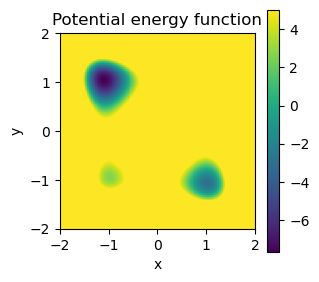

In [2]:

# Number of dimensions
Nd     =  2  

# System parameters assuming overdamped Langevin dynamics
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

# Initialize the variables x and y for symbolic calculation
x,y   =  sp.symbols('x,y')

# Potential energy function
V       = 10*(x**2 - 1)**2 + 5*x*y + 0*y**2 + 2.2*x + 10*(y**2-1)**2 

# Calculate gradient with sympy
gradVx  =  V.diff(x)
gradVy  =  V.diff(y)

# To display sympy functions:
# display(gradVx)
# display(gradVy)

# Convert potential and gradient into numpy functions
V       =  sp.lambdify((x,y), V, modules=['numpy'])
gradVx  =  sp.lambdify((x,y), gradVx, modules=['numpy'])
gradVy  =  sp.lambdify((x,y), gradVy, modules=['numpy'])


# Grid for figure
xbins  = 300  
xmin   = -2
xmax   =  2

ybins  = 300 
ymin   = -2
ymax   =  2

xedges = np.linspace(xmin, xmax, xbins)  
dx     = xedges[1] - xedges[0]
x      = xedges[:-1] + (dx / 2)                
xbins  = xbins - 1

yedges = np.linspace(ymin, ymax, ybins) 
dy     = yedges[1] - yedges[0]
y      = yedges[:-1] + (dy / 2)
ybins  = ybins - 1

grid = np.meshgrid(x,y)

# Bins of the grid
Nbins  = xbins * ybins                    

# plot potential energy function
fig, ax1 = plt.subplots(1, 1,figsize=(8*in2cm, 8*in2cm))  

pos = ax1.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)
ax1.set_title('Potential energy function')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
fig.colorbar(pos, ax=ax1)

# Explore state space
The next cell generates a long trajectory that covers the entire state space and save Npoints representative states.

(-2.0, 2.0)

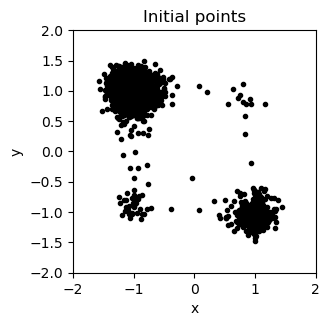

In [3]:
# Integrator timestep
dt = 0.001
sdt = np.sqrt(dt)

# Total number of timesteps
Nsteps   = 10000000

# Initialize array where to store the trajectory
r        = np.zeros((Nsteps, Nd))

# Initial point
x0       = -1
y0       = 1

r[0,0] = x0
r[0,1] = y0

# Implement Euler-Maruyama scheme
for k in range(Nsteps-1):
    eta    =  np.random.normal(0, 1, 2)
    forcex  =  - gradVx(r[k,0], r[k,1])
    forcey  =  - gradVy(r[k,0], r[k,1])
    r[k+1,0]     =  r[k,0] + 1 / mass / gamma * forcex * dt + sigma * eta[0] * sdt
    r[k+1,1]     =  r[k,1] + 1 / mass / gamma * forcey * dt + sigma * eta[1] * sdt


# Number of starting points for ISOKANN
N        = 2000

# Initialize array for the initial points
X0 = np.zeros((N, Nd))

# Define interval to select points from long trajectory
Nf = int(Nsteps/N)

# Select every Nf points from r, from the first element until the end of the array.
X0[:,0] = r[0::Nf,0]
X0[:,1] = r[0::Nf,1]


# Plot initial points
fig, ax1 = plt.subplots(1, 1,figsize=(8*in2cm, 8*in2cm))  
ax1.plot(X0[:,0], X0[:,1], 'k.')
ax1.set_title('Initial points')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# Propagate dynamics
The next cell generates a short trajectories starting from the initial points

In [4]:
# Number of short trajectories
M        = 10

# Number of timesteps of each short trajectory
Nsteps   = 100

# Initialize array Xtau
Xt = np.zeros((N, M, Nd))


for n in range(N):

    # Initialize array for M short trajectories starting in the n-th point
    r  = np.zeros((Nsteps, M, Nd))
    r[0,:,0]  = X0[n,0] * np.ones(M)
    r[0,:,1]  = X0[n,1] * np.ones(M)

    j  = 0
    for k in range(Nsteps-1):

        eta     =  np.random.normal(0, 1, (M,2))
        forcex  =  - gradVx(r[k,:,0], r[k,:,1])
        forcey  =  - gradVy(r[k,:,0], r[k,:,1])
        r[k+1,:,0]     =  r[k,:,0] + 1 / mass / gamma * forcex * dt + sigma * eta[:,0] * sdt
        r[k+1,:,1]     =  r[k,:,1] + 1 / mass / gamma * forcey * dt + sigma * eta[:,1] * sdt
        
    Xt[n,:,0] = r[-1,:,0]
    Xt[n,:,1] = r[-1,:,1]




(-2.0, 2.0)

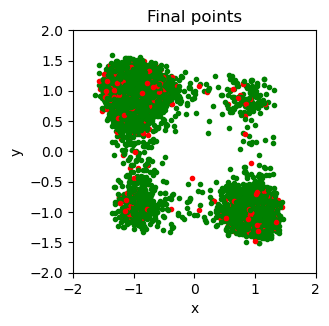

In [5]:
# Plot final points for specific initial points
n = 0
fig, ax1 = plt.subplots(1, 1,figsize=(8*in2cm, 8*in2cm))  

for n in range(0,N,1):
    ax1.plot(Xt[n,:,0], Xt[n,:,1], 'g.')
    ax1.plot(X0[n,0], X0[n,1], 'r.')
ax1.set_title('Final points')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

In [6]:
np.save(out_trajectories + 'X0.npy', X0)
np.save(out_trajectories + 'Xt.npy', Xt)
